In [3]:
import os
import shutil
import numpy as np
from glob import glob
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.colors import Normalize
import librosa
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize 
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [24]:
os.chdir('C:\\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY')

In [17]:
y, sr = librosa.load(files[0], sr=44100)
print(librosa.get_duration(y=y, sr=44100))

0.25


In [8]:
files = glob(os.path.join(os.getcwd(), '*'))

In [28]:
all_files = glob(os.path.join(os.getcwd(), '*'))

# Filter out files starting with 'd307'
files = [file for file in all_files if not os.path.basename(file).startswith('d307')]

In [132]:
filesArrays = [librosa.load(file, sr=44100)[0] for file in files]

In [48]:
# for file in files:
#     y, sr = librosa.load(file, sr=44100)
#     duration_sec = librosa.get_duration(y=y, sr=sr)
#     if duration_sec < 0.25:
#         print(file, librosa.get_duration(y=audio, sr=sr))

NameError: name 'audio' is not defined

In [6]:
chunk, sr = librosa.load(files[0], sr=44100)
features = extract_features(chunk, sr)
print(features.shape)

(3674,)


Remove all of the files from the directory that were recorded with a device other than a DADS array: Device # 306, 307, or 308

In [4]:
# # Define the prefixes to keep
# prefixes_to_keep = ['d306', 'd307', 'd308']

# # Get list of all files in the directory
# files = glob(os.path.join(os.getcwd(), '*'))

# # Iterate through files and delete those not starting with the specified prefixes
# for file in files:
#     filename = os.path.basename(file)
#     if not any(filename.startswith(prefix) for prefix in prefixes_to_keep):
#         print(filename)
#         # os.remove(file)
#         # print(f"Deleted: {filename}")

# print("Deletion complete.")

Deletion complete.


Now, with a smaller dataset, take 13 mfccs, the delta 1s, and delta 2s from each file and then cluster across the entire dataset, then with your 2 clusters determine which one is drone and which one is not drone, then you will have labels for each of your files. Update the spreadsheet accordingly

In [32]:
# Extract features for each chunk (example: using MFCC)
def extract_features(chunk, sr):
    chunk = (chunk-min(chunk))/(max(chunk)-min(chunk))
    S = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=128)
    chroma = librosa.feature.chroma_stft(S=np.abs(librosa.stft(S)), sr=sr)
    mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    flat_S = S.flatten()
    flat_chroma = chroma.flatten()
    flat_mfcc = mfcc.flatten()
    flat_mfcc_delta = mfcc_delta.flatten()
    flat_mfcc_delta2 = mfcc_delta2.flatten()
    
    features = np.hstack((flat_S, flat_chroma, flat_mfcc, flat_mfcc_delta, flat_mfcc_delta2))
    return features

ADD TRY CATCH

somehow there are a few corrupt chunks, 

Cluster 0: Chunks = [    0     1     2 ... 80666 80668 80669]
Cluster 1: Chunks = [ 1528  1538  1554 ... 81825 81826 81827]
MFCC 1 Mean Differences:
Cluster 0 to Cluster 1: -7.1837158203125
MFCC 2 Mean Differences:
Cluster 0 to Cluster 1: -17.4122314453125
MFCC 3 Mean Differences:
Cluster 0 to Cluster 1: -18.8199462890625
MFCC 4 Mean Differences:
Cluster 0 to Cluster 1: -16.927490234375
MFCC 5 Mean Differences:
Cluster 0 to Cluster 1: -18.912841796875
MFCC 6 Mean Differences:
Cluster 0 to Cluster 1: -17.3582763671875
MFCC 7 Mean Differences:
Cluster 0 to Cluster 1: -19.0025634765625
MFCC 8 Mean Differences:
Cluster 0 to Cluster 1: -18.8009033203125
MFCC 9 Mean Differences:
Cluster 0 to Cluster 1: -17.657958984375
MFCC 10 Mean Differences:
Cluster 0 to Cluster 1: -17.8558349609375
MFCC 11 Mean Differences:
Cluster 0 to Cluster 1: -18.1444091796875
MFCC 12 Mean Differences:
Cluster 0 to Cluster 1: -16.806640625
MFCC 13 Mean Differences:
Cluster 0 to Cluster 1: -18.9007568359375
MFCC 14 M

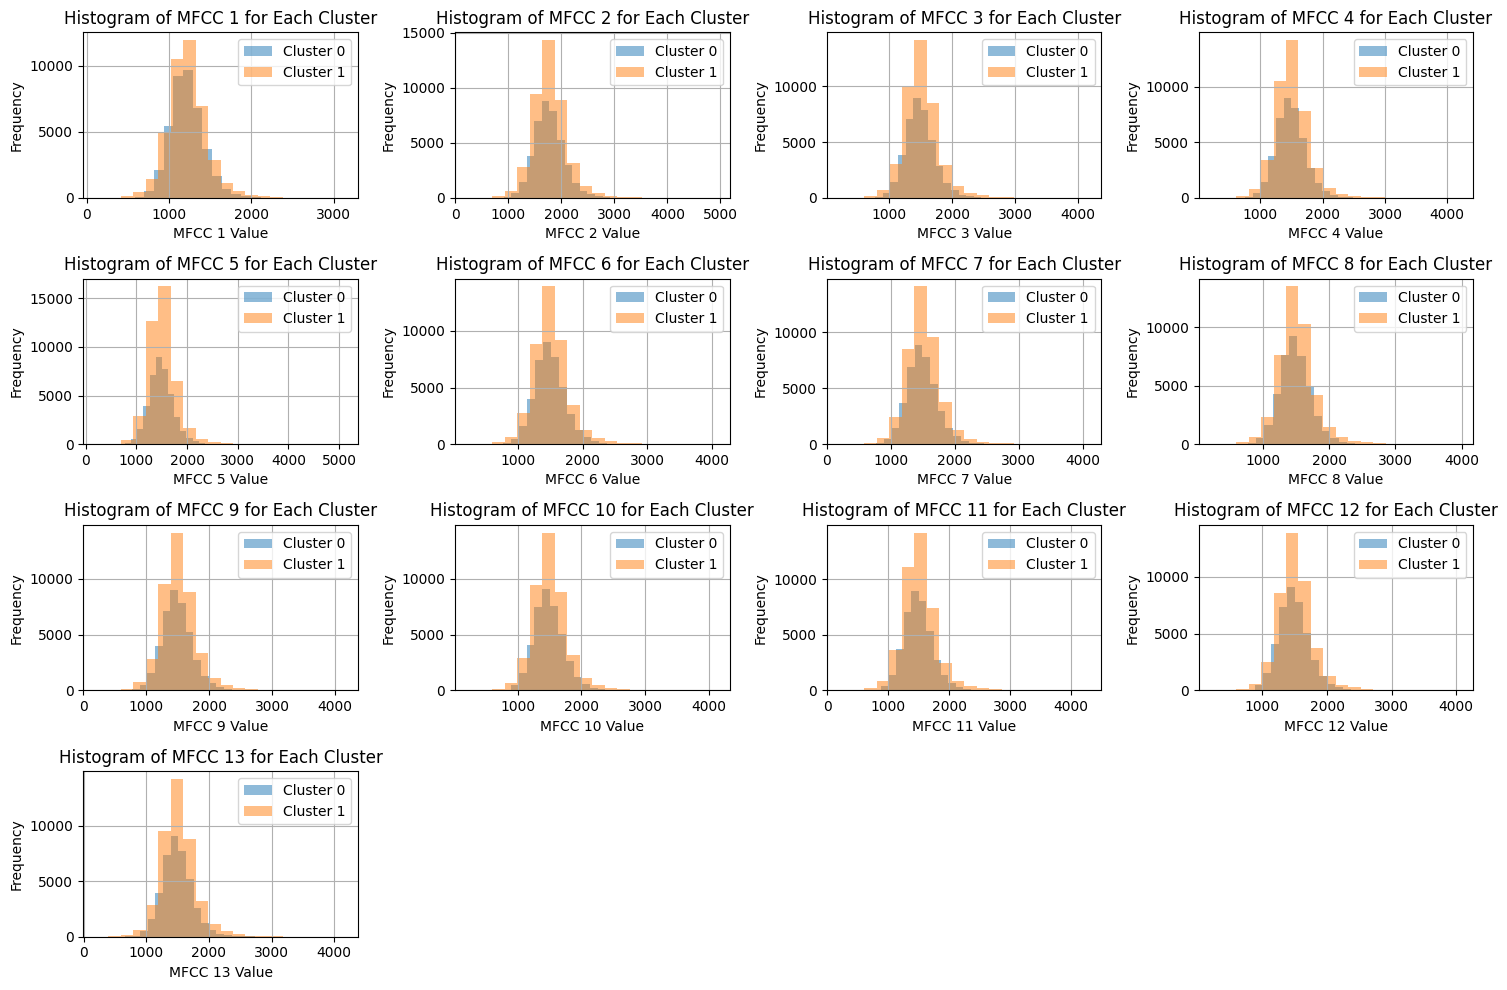

In [34]:
# X = []
# count = 0
# for chunk in files:
#     count += 1
#     try:
#         chunk, sr = librosa.load(chunk, sr=44100)
#         features = extract_features(chunk, sr)
#         X.append(features)
#     except Exception as e:
#         print(f"Error processing {chunk}: {str(e)}")
#     print(count)

# # Convert lists to numpy arrays
# X = np.array(X)
# y_labels = np.array(y_labels)

#X = np.reshape(X, (X.shape[0], -1))

# # Normalize feature matrix (optional but often recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
n_clusters = 2  # Specify number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Initialize lists to store chunk indices for each cluster
cluster_indices = [[] for _ in range(n_clusters)]

# Collect chunk indices for each cluster
for chunk_index, label in enumerate(cluster_labels):
    cluster_indices[label].append(chunk_index)

# Convert lists to numpy arrays if needed
cluster_indices = [np.array(indices) for indices in cluster_indices]

# Print cluster indices
for i, indices in enumerate(cluster_indices):
    print(f"Cluster {i}: Chunks = {indices}")

cluster_means = []
for cluster in range(n_clusters):
    cluster_means.append(np.mean(X[cluster_labels == cluster], axis=0))

# Convert cluster_means to numpy array for easier manipulation
cluster_means = np.array(cluster_means)

# Compute differences between cluster means of each MFCC coefficient
mean_differences = np.zeros((n_clusters, n_clusters, X.shape[1]))  # 3D array: (cluster1, cluster2, MFCC coefficient)
for i in range(n_clusters):
    for j in range(n_clusters):
        mean_differences[i, j] = cluster_means[i] - cluster_means[j]

# Print mean differences for each MFCC coefficient
for mfcc_idx in range(X.shape[1]):
    print(f"MFCC {mfcc_idx + 1} Mean Differences:")
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            print(f"Cluster {i} to Cluster {j}: {mean_differences[i, j, mfcc_idx]}")

# Plot histograms for all MFCC coefficients
plt.figure(figsize=(15, 10))
for i in range(13):
    plt.subplot(4, 4, i + 1)  # Adjust subplot layout based on number of MFCCs
    for cluster in range(n_clusters):
        plt.hist(X[cluster_labels == cluster, i], bins=20, alpha=0.5, label=f'Cluster {cluster}')
    plt.xlabel(f'MFCC {i + 1} Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of MFCC {i + 1} for Each Cluster')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [149]:
for i in range(len(filesArrays)):
    if len(filesArrays[i]) != 11025:
        filesArrays[i] = np.append(filesArrays[i], 0)

In [183]:
scaler = StandardScaler()
files_scaled = scaler.fit_transform(filesArrays) 

files_normalized = normalize(files_scaled) 

pca = PCA(n_components = 3) 
files_principal = pca.fit_transform(files_normalized) 
files_principal = pd.DataFrame(files_principal)
files_principal.columns = ['P1', 'P2', 'P3'] 

In [167]:
db_default = DBSCAN(eps=1.05, min_samples=5).fit(files_principal) 
labels = db_default.labels_ 

In [168]:
set(labels)

{0}

In [190]:
files_principal.head()

,P1,P2,P3
0,-0.016345,-0.000700,-0.010702
1,-0.019810,0.022373,-0.022646
2,0.003067,0.007183,-0.035097
3,0.003849,-0.042888,-0.009629
4,-0.013961,-0.014905,0.030289


In [189]:
files_principal.tail()

,P1,P2,P3
82347,-0.006163,-0.014621,0.021058
82348,-0.012352,0.024956,0.000255
82349,0.011332,-0.070757,-0.010166
82350,-0.031824,-0.029695,-0.009452
82351,-0.019913,0.036177,-0.042217


Cluster 0: Chunks = [   10    13    24 ... 82338 82339 82341]
Cluster 1: Chunks = [    0     1     2 ... 82349 82350 82351]


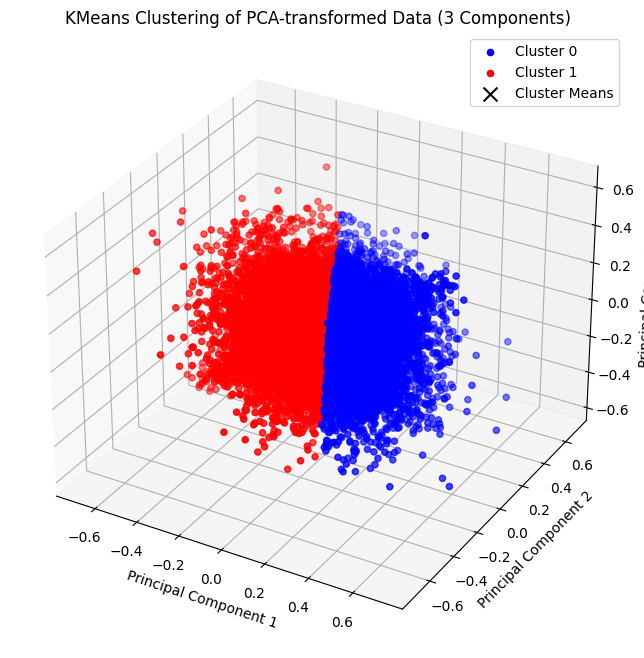

In [186]:
# Apply K-means clustering
n_clusters = 2  # Specify number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(files_principal)

# Initialize lists to store chunk indices for each cluster
cluster_indices = [[] for _ in range(n_clusters)]

# Collect chunk indices for each cluster
for chunk_index, label in enumerate(cluster_labels):
    cluster_indices[label].append(chunk_index)

# Convert lists to numpy arrays if needed
cluster_indices = [np.array(indices) for indices in cluster_indices]

# Print cluster indices
for i, indices in enumerate(cluster_indices):
    print(f"Cluster {i}: Chunks = {indices}")

cluster_means = []
for cluster in range(n_clusters):
    cluster_means.append(np.mean(files_principal[cluster_labels == cluster], axis=0))

# Convert cluster_means to numpy array for easier manipulation
cluster_means = np.array(cluster_means)

# # Plotting the clusters
# plt.figure(figsize=(10, 8))

# # Scatter plot for cluster 0
# plt.scatter(files_principal.loc[cluster_labels == 0, 'P1'], files_principal.loc[cluster_labels == 0, 'P2'], color='blue', label='Cluster 0')

# # Scatter plot for cluster 1
# plt.scatter(files_principal.loc[cluster_labels == 1, 'P1'], files_principal.loc[cluster_labels == 1, 'P2'], color='red', label='Cluster 1')

# plt.title('Scatter Plot of Clusters')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.grid(True)
# plt.show()


#CODE FOR 3 PCA COMPONENTS PLOTTING

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for cluster 0
ax.scatter(files_principal.loc[cluster_labels == 0, 'P1'], files_principal.loc[cluster_labels == 0, 'P2'], files_principal.loc[cluster_labels == 0, 'P3'], color='blue', label='Cluster 0')

# Scatter plot for cluster 1
ax.scatter(files_principal.loc[cluster_labels == 1, 'P1'], files_principal.loc[cluster_labels == 1, 'P2'], files_principal.loc[cluster_labels == 1, 'P3'], color='red', label='Cluster 1')

# Plot cluster centroids
ax.scatter(cluster_means[:, 0], cluster_means[:, 1], cluster_means[:, 2], color='black', marker='x', s=100, label='Cluster Means')

ax.set_title('KMeans Clustering of PCA-transformed Data (3 Components)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.grid(True)
plt.show()

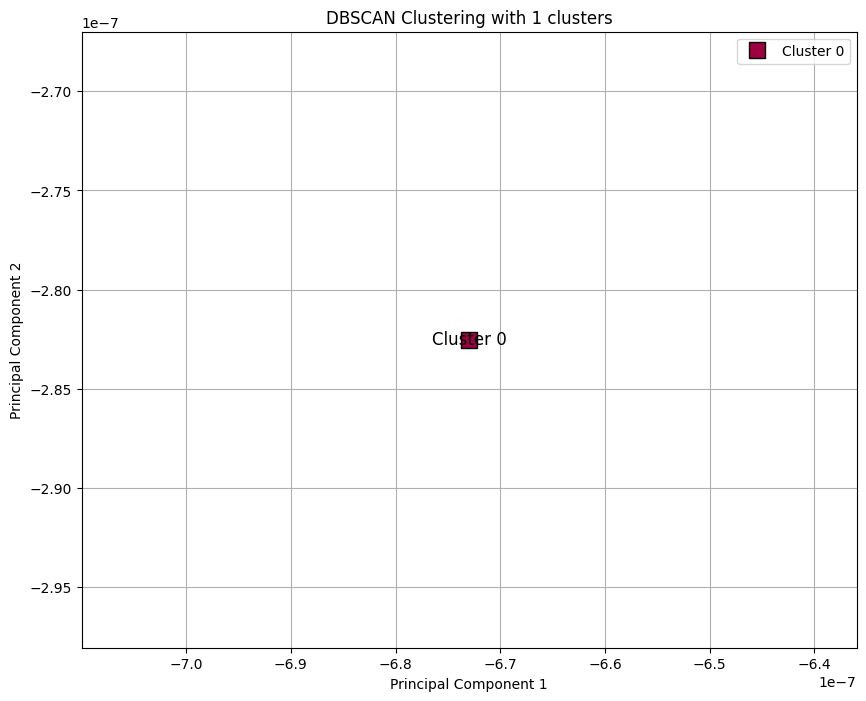

In [116]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Plotting the clusters with centroids/means
plt.figure(figsize=(10, 8))

# All points (including noise/outliers)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# Calculate and plot centroid/mean of each cluster
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise points (cluster -1)

    cluster_mean = np.mean(X_principal[labels == k], axis=0)
    plt.plot(cluster_mean[0], cluster_mean[1], 's', markerfacecolor=tuple(col), markeredgecolor='k', markersize=12)

    # Annotate centroid/mean with cluster label
    plt.text(cluster_mean[0], cluster_mean[1], f'Cluster {k}', fontsize=12, ha='center', va='center')

plt.title(f'DBSCAN Clustering with {n_clusters_} clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend([f'Cluster {i}' for i in unique_labels], loc='upper right')
plt.grid(True)
plt.show()

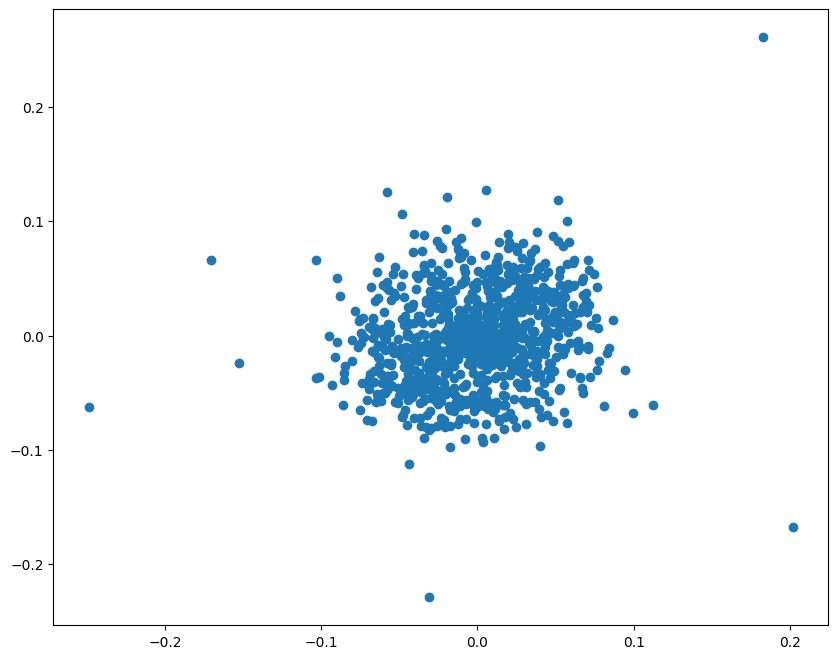

In [175]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(files_principal['P1'][:1000], files_principal['P2'][:1000])
plt.show()

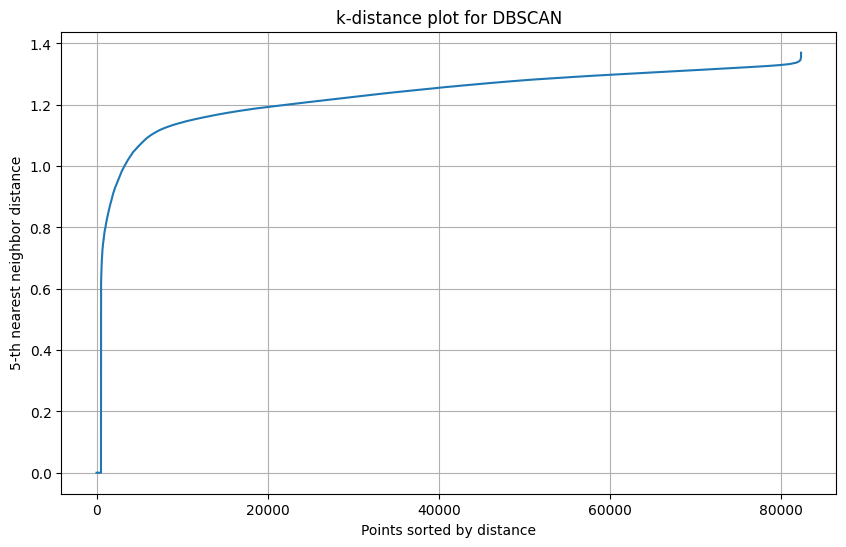

In [156]:
# Compute distances to the k-th nearest neighbor
k = 5  # Choose an appropriate value for k
nbrs = NearestNeighbors(n_neighbors=k).fit(files_normalized)
distances, _ = nbrs.kneighbors(files_normalized)

# Sort the distances of each point by the k-th nearest neighbor
sorted_distances = np.sort(distances[:, -1])

# Plotting the k-distance plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(files_normalized)), sorted_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.title(f'k-distance plot for DBSCAN')
plt.grid(True)
plt.show()

In [18]:
len(cluster_indices[1])

30241

Create a spreadsheet with the cluster labels for each file

In [187]:
# Create a list to hold (file name, cluster index) pairs
data = []

# Populate the list with file names and their corresponding cluster indices
for cluster_index, indices in enumerate(cluster_indices):
    for idx in indices:
        data.append((files[idx], cluster_index))

# Create a DataFrame from the list
df = pd.DataFrame(data, columns=['File Name', 'Cluster Index'])

# Write DataFrame to an Excel file
excel_file = 'C:\\Users\Alec\Desktop\clustered_files.xlsx'  # Specify the Excel file name/path
df.to_excel(excel_file, index=False)

print(f"DataFrame successfully written to {excel_file}")

DataFrame successfully written to C:\Users\Alec\Desktop\clustered_files.xlsx


In [188]:
excel_file = 'C:\\Users\Alec\Desktop\clustered_files.xlsx' 
output_excel_file = r'C:\Users\Alec\Desktop\clustered_files_sorted.xlsx'  # Output Excel file path

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file)

# Sort DataFrame by 'File Name' to ensure file names are in order
df_sorted = df.sort_values(by='File Name')

# Write the sorted DataFrame to Excel
df_sorted.to_excel(output_excel_file, index=False)

print(f"Data has been written to {output_excel_file}")

Data has been written to C:\Users\Alec\Desktop\clustered_files_sorted.xlsx


In [15]:
excel_file = r'C:\Users\Alec\Desktop\mfcc_clustered_files.xlsx'

# Desired prefix to match
desired_prefix = 'd306sA2r16p0220210826'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file)

# Filter rows where the 'File Name' column contains the desired prefix
filtered_df = df[df['File Name'].str.contains(desired_prefix)]

# Print segments and their clusters
for index, row in filtered_df.iterrows():
    file_name = row['File Name']
    cluster_index = row['Cluster Index']
    print(f"Segment: {file_name} -> Cluster {cluster_index}")

Segment: C:\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\d306sA2r16p0220210826_segment_0000.wav -> Cluster 0
Segment: C:\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\d306sA2r16p0220210826_segment_0001.wav -> Cluster 0
Segment: C:\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\d306sA2r16p0220210826_segment_0002.wav -> Cluster 0
Segment: C:\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\d306sA2r16p0220210826_segment_0003.wav -> Cluster 0
Segment: C:\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\d306sA2r16p0220210826_segment_0004.wav -> Cluster 0
Segment: C:\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\d306sA2r16p0220210826_segment_0005.wav -> Cluster 0
Segment: C:\Users\Alec\Desktop\SIT

Get list of files that have at least one segment in each cluster

In [16]:
excel_file = r'C:\Users\Alec\Desktop\mfcc_clustered_files.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file)

# Filter segments in cluster 0
cluster_0_files = set(df[df['Cluster Index'] == 0]['File Name'])

# Filter segments in cluster 1
cluster_1_files = set(df[df['Cluster Index'] == 1]['File Name'])

# Find files with segments in both clusters
files_in_both_clusters = cluster_0_files.intersection(cluster_1_files)

# Print file names in both clusters
print("Files with at least one segment in both cluster 0 and cluster 1:")
for file_name in files_in_both_clusters:
    print(f"- {file_name}")

Files with at least one segment in both cluster 0 and cluster 1:


In [68]:
specified_string = 'd308sA2r24p0420210825'  # Example: Searching for files containing 'sA1'

# Print cluster_0_files containing the specified substring
print(f"Files in cluster 0 containing '{specified_string}':")
for file_name in cluster_1_files:
    if specified_string in file_name:
        print(f"- {file_name}")

Files in cluster 0 containing 'd308sA2r24p0420210825':


In [64]:
cluster_0_files

{'C:\\Users\\Alec\\Desktop\\SIT_acoustic\\ESCAPE_FORMAT_ONECHANNEL\\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\\d306sA2r24p0220210825_segment_0187.wav',
 'C:\\Users\\Alec\\Desktop\\SIT_acoustic\\ESCAPE_FORMAT_ONECHANNEL\\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\\d307sA2r23p0120210825_segment_0297.wav',
 'C:\\Users\\Alec\\Desktop\\SIT_acoustic\\ESCAPE_FORMAT_ONECHANNEL\\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\\d308sA3r03p0120210827_segment_0410.wav',
 'C:\\Users\\Alec\\Desktop\\SIT_acoustic\\ESCAPE_FORMAT_ONECHANNEL\\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\\d308sA3r06p0220210827_segment_0072.wav',
 'C:\\Users\\Alec\\Desktop\\SIT_acoustic\\ESCAPE_FORMAT_ONECHANNEL\\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\\d306sA2r23p0220210825_segment_0287.wav',
 'C:\\Users\\Alec\\Desktop\\SIT_acoustic\\ESCAPE_FORMAT_ONECHANNEL\\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\\d306sA2r26p0320210826_segment_0230.wav',
 'C:\\Users\\Alec\\Desktop\\SIT_acoustic\\ESCAPE_FORMAT_ONECHANNEL\\ESCAPE_II_ONECHANNEL_PROCESSED_D

In [11]:
X.shape

(130305, 13, 66)

C:\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\ESCAPE_II_ONECHANNEL_PROCESSED_DADSONLY\d308sA2r18p0120210825_segment_0002.wav


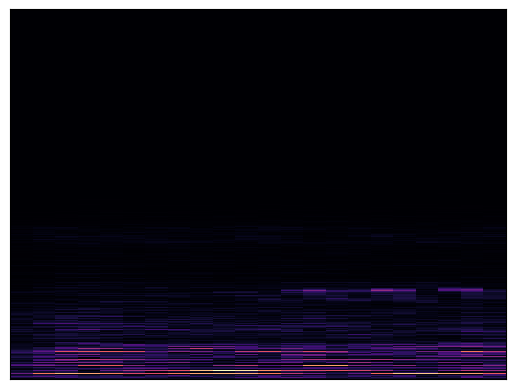

In [28]:
print(files[110181])
y, sr = librosa.load(files[5], sr=44100)
S = librosa.stft(y)
librosa.display.specshow(np.abs(S))